# Noise2Self-inspired Optopatch moving denoising

In [ ]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace
from cellmincer.opto_utils import crop_center, get_nn_spatio_temporal_mean
from cellmincer.opto_denoise import get_unet_input_size
from cellmincer.opto_denoise import UNet, ConvolutionalTemporalCombiner, \
    generate_occluded_training_data, get_loss, \
    generate_input_for_denoising, denoise

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(30, 10)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

## Configuration

In [ ]:
# list of Optopatch movies
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy'
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'
if not os.path.exists(output_path):
    os.mkdir(output_path)

### Model config

In [ ]:
# this configuration requires 16gb of GPU memory (e.g. Tesla V100)
denoiser_config = {
    'unet_depth': 2,  # depth of a unet per-frame feature extractor
    'unet_wf': 4,  # log number of unet filters in the first layer
    'unet_out_channels_per_frame': 1,  # number of unet output channels per frame
    't_order': 15,  # denoising filter tarps
    'occlusion_prob': 0.01,  # fraction of pixels to occlude during training
    'batch_norm': False,  # enable batch norm (False)
    'combiner_kernel_size': 3, # spatial kernel size of the temporal combiner
    'combiner_hidden_channels_list': [64, 32, 16, 8], # conv channels of the combiner
}

In [ ]:
movie_width = 512
movie_height = 180

padded_width = get_unet_input_size(
    output_min_size=(
        movie_width
        + (denoiser_config['combiner_kernel_size'] - 1) * (
            len(denoiser_config['combiner_hidden_channels_list']) + 1)),
    kernel_size=3,
    depth=denoiser_config['unet_depth'])

padded_height = get_unet_input_size(
    output_min_size=(
        movie_height
        + (denoiser_config['combiner_kernel_size'] - 1) * (
            len(denoiser_config['combiner_hidden_channels_list']) + 1)),
    kernel_size=3,
    depth=denoiser_config['unet_depth'])

assert denoiser_config['t_order'] > 0 and denoiser_config['t_order'] % 2 == 1
assert 0. < denoiser_config['occlusion_prob'] < 1.0

## Load datasets

In [6]:
# setup datasets
ws_base_list = []
for opto_mov_path in opto_mov_path_list:
    ws_base_list.append(OptopatchBaseWorkspace(opto_mov_path, logger))
n_datasets = len(ws_base_list)

ws_denoising_list = []
for ws_base in ws_base_list:
    assert ws_base.width == movie_width
    assert ws_base.height == movie_height
    ws_denoising = OptopatchDenoisingWorkspace(ws_base, padded_width, padded_height)
    ws_denoising_list.append(ws_denoising)

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std

## Instantiate the denoising model

In [7]:
unet_input_channels = (
    # global features
    ws_denoising_list[0].n_global_features
    # the actual frame
    + 1 
)

per_frame_feature_extractor = UNet(
    in_channels=unet_input_channels,
    out_channels=denoiser_config['unet_out_channels_per_frame'],
    depth=denoiser_config['unet_depth'],
    wf=denoiser_config['unet_wf'], 
    padding=False,
    batch_norm=denoiser_config['batch_norm'], 
    up_mode='upconv',
    device=device,
    dtype=dtype)

combiner_input_channels = (
    # global features
    ws_denoising_list[0].n_global_features
    # encoded features of t_order consecutive frames
    + denoiser_config['t_order'] * denoiser_config['unet_out_channels_per_frame']
)

temporal_combiner = ConvolutionalTemporalCombiner(
    input_channels=combiner_input_channels,
    hidden_layer_channels_list=denoiser_config['combiner_hidden_channels_list'],
    kernel_size=denoiser_config['combiner_kernel_size'],
    batch_norm=denoiser_config['batch_norm'], 
    device=device,
    dtype=dtype)

### Load parameters (optional)

In [8]:
all_params = (
    list(per_frame_feature_extractor.parameters()) +
    list(temporal_combiner.parameters())
)
optim = torch.optim.Adam(all_params, lr=1e-3, betas=(0.99, 0.999))

In [9]:
enable_continuity_reg = False
continuity_reg_strength = 2.0
noise_threshold_to_std = 0.02
reg_func = 'clamped_linear'

if enable_continuity_reg:
    model_name = 'reg_' + reg_func
    model_prefix = f'{model_name}__{continuity_reg_strength:.2f}_{noise_threshold_to_std:.2f}'
else:
    model_name = 'unreg'
    model_prefix = f'{model_name}'
    
with open(f'./denoiser_config__{model_prefix}.json', 'w') as f:
    json.dump(denoiser_config, f)

per_frame_feature_extractor.load_state_dict(
    torch.load(f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/unet__{model_prefix}.pt'))
temporal_combiner.load_state_dict(
    torch.load(f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/combiner__{model_prefix}.pt'))
try:
    optim.load_state_dict(
        torch.load(f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/adam_state__{model_prefix}.pt'))
except:
    pass

### Train

In [ ]:
total_loss_hist = []
rec_loss_hist = []

In [ ]:
n_batch = 5
t_tandem = 10
norm_p = 1
only_fg_pixels = False

enable_continuity_reg = True
continuity_reg_strength = 1.0
noise_threshold_to_std = 0.02
reg_func = 'tanh'

n_iters = 20_000
log_every = 10

per_frame_feature_extractor.train()
temporal_combiner.train()

torch.cuda.empty_cache()

for i_iter in range(n_iters):
    
    batch_data = generate_occluded_training_data(
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        t_order=denoiser_config['t_order'],
        t_tandem=t_tandem,
        n_batch=n_batch,
        occlusion_prob=denoiser_config['occlusion_prob'],
        only_fg_pixels=only_fg_pixels,
        continuity_reg_strength=continuity_reg_strength,
        noise_threshold_to_std=noise_threshold_to_std,
        device=device,
        dtype=dtype)
        
    total_loss, rec_loss = get_loss(
        batch_data=batch_data,
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        per_frame_feature_extractor=per_frame_feature_extractor,
        temporal_combiner=temporal_combiner,
        norm_p=norm_p,
        enable_continuity_reg=enable_continuity_reg,
        reg_func=reg_func)

    optim.zero_grad()
    total_loss.backward()
    optim.step()

    loss_scale = batch_data['padded_occlusion_masks_ntxy'].sum().item()
    total_loss_hist.append(total_loss.item() / loss_scale)
    rec_loss_hist.append(rec_loss.item() / loss_scale)
    
    if i_iter % log_every == 0:
        print(f"iter: {i_iter}, "
              f"total loss: {total_loss_hist[-1]:.3}, "
              f"reconstruction loss: {rec_loss_hist[-1]:.3}")

In [ ]:
plt.plot(total_loss_hist)

In [ ]:
np.save(
    f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/total_loss_hist__{model_prefix}.npy',
    loss_hist)
np.save(
    f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/rec_loss_hist__{model_prefix}.npy',
    loss_hist)

## Save the model

In [ ]:
if enable_continuity_reg:
    model_name = 'reg_' + reg_func
    model_prefix = f'{model_name}__{continuity_reg_strength:.2f}_{noise_threshold_to_std:.2f}'
else:
    model_name = 'unreg'
    model_prefix = f'{model_name}'
    
with open(f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/denoiser_config__{model_prefix}.json', 'w') as f:
    json.dump(denoiser_config, f)
    
torch.save(
    per_frame_feature_extractor.state_dict(),
    f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/unet__{model_prefix}.pt')
torch.save(
    temporal_combiner.state_dict(),
    f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/combiner__{model_prefix}.pt')
torch.save(
    optim.state_dict(),
    f'/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models/adam_state__{model_prefix}.pt')

## Plot a few denoised pixel traces

In [25]:
i_dataset = 0

i_t_begin = 50
i_t_end = 600

denoised_movie_txy = np.zeros(
    (i_t_end - i_t_begin, movie_width, movie_height),
    dtype=np.float32)

for i_t in range(i_t_begin, i_t_end):
    
    denoising_input_data = generate_input_for_denoising(
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        i_dataset=i_dataset,
        i_t=i_t,
        t_order=denoiser_config['t_order'],
        device=device,
        dtype=dtype)

    denoised_frame_xy = denoise(
        denoising_input_data,
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        per_frame_feature_extractor=per_frame_feature_extractor,
        temporal_combiner=temporal_combiner)
    
    denoised_movie_txy[i_t - i_t_begin, ...] = denoised_frame_xy.cpu().numpy()
    
del denoising_input_data
del denoised_frame_xy
torch.cuda.empty_cache()

In [11]:
# baseline: spatio temporal mean
nnma_denoised_movie_txy = np.zeros(
    (i_t_end - i_t_begin, movie_width, movie_height),
    dtype=np.float32)
for i_t in range(i_t_begin, i_t_end):
    nnma_denoised_movie_txy[i_t - i_t_begin, ...] = \
        crop_center(
            get_nn_spatio_temporal_mean(ws_denoising_list[i_dataset].padded_movie_1txy, i_t)[0, ...],
            target_width=movie_width,
            target_height=movie_height)
    
# raw
raw_movie_txy = np.zeros(
    (i_t_end - i_t_begin, movie_width, movie_height),
    dtype=np.float32)
for i_t in range(i_t_begin, i_t_end):
    raw_movie_txy[i_t - i_t_begin, ...] = \
        crop_center(
            ws_denoising_list[i_dataset].padded_movie_1txy[:, i_t, ...],
            target_width=movie_width,
            target_height=movie_height)

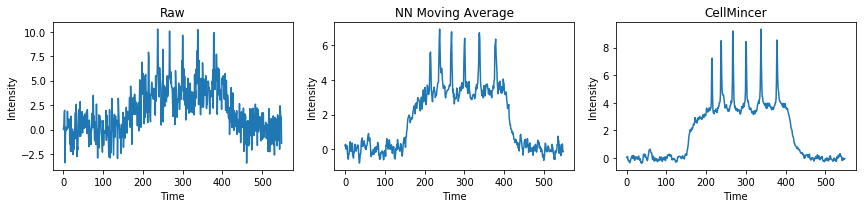

In [33]:
x0, y0 = 393, 65
# x0, y0 = 490, 126
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].plot(raw_movie_txy[:, x0, y0])
axs[0].set_title('Raw')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Intensity')

axs[1].plot(nnma_denoised_movie_txy[:, x0, y0])
axs[1].set_title('NN Moving Average')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Intensity')

axs[2].plot(denoised_movie_txy[:, x0, y0])
axs[2].set_title('CellMincer')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Intensity')

plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset]}_{x0}_{y0}.pdf')

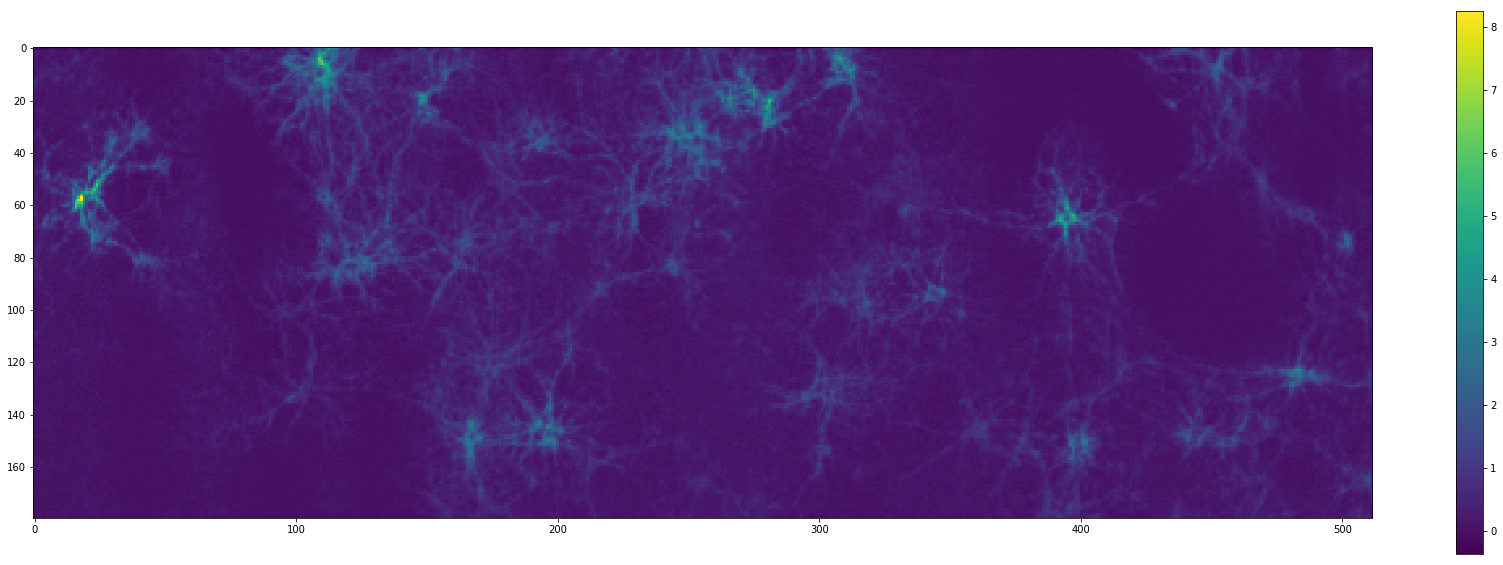

In [14]:
fig, ax = new_fig()
im = plt.imshow(denoised_movie_txy[350, ...].T)
plt.colorbar(im)

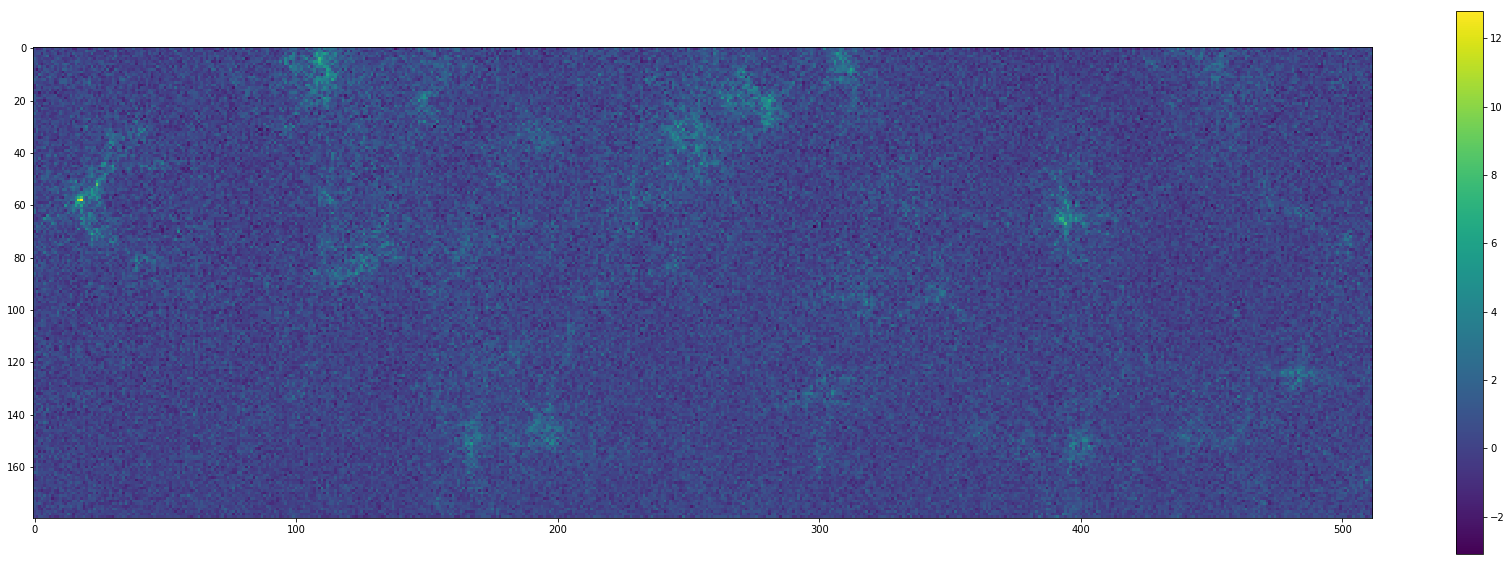

In [15]:
fig, ax = new_fig()
im = plt.imshow(raw_movie_txy[350, ...].T)
plt.colorbar(im)

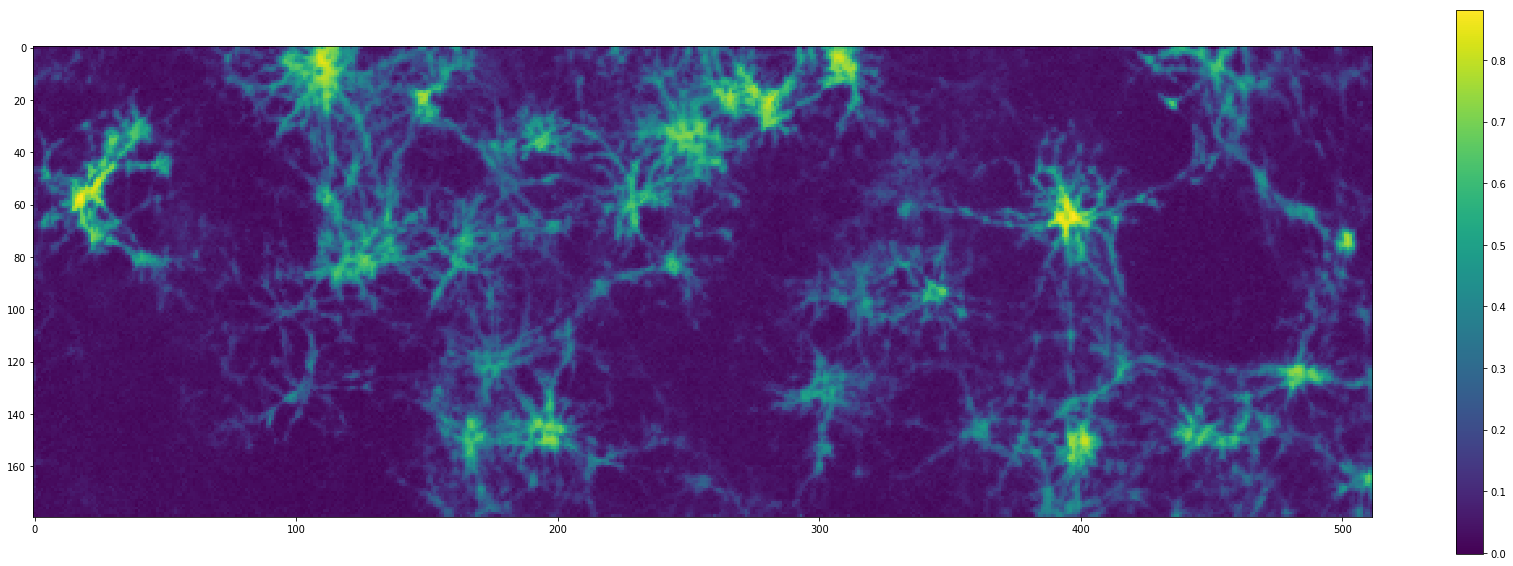

In [16]:
fig, ax = new_fig()
im = plt.imshow(ws_base_list[i_dataset].movie_t_corr_xy.T)
plt.colorbar(im)

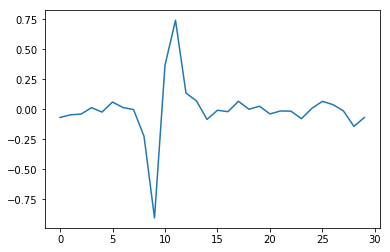

In [17]:
plt.plot((denoised_movie_txy[220:250, x0, y0] - denoised_movie_txy[221:251, x0, y0]) / (
    ws_base_list[i_dataset].movie_t_std_xy[x0, y0] / ws_denoising_list[i_dataset].fg_scale))

## Generate denoised datasets

In [ ]:
for i_dataset in range(1, len(ws_base_list)):

    t_mid = (denoiser_config['t_order'] - 1) // 2
    denoised_movie_txy = np.zeros_like(ws_base_list[i_dataset].movie_txy)
    log_frequency = 500
    total_frames = ws_base_list[i_dataset].n_frames - t_mid
    t0 = time()

    for i_t in range(t_mid, total_frames):

        denoising_input_data = generate_input_for_denoising(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            i_dataset=i_dataset,
            i_t=i_t,
            t_order=denoiser_config['t_order'],
            device=device,
            dtype=dtype)

        denoised_frame_xy = denoise(
            denoising_input_data,
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            per_frame_feature_extractor=per_frame_feature_extractor,
            temporal_combiner=temporal_combiner)

        denoised_movie_txy[i_t, ...] = denoised_frame_xy.cpu().numpy()

        if (i_t - t_mid) % log_frequency == 0 and i_t > t_mid:
            fps = log_frequency / (time() - t0)
            t0 = time()
            print(f'[{opto_mov_prefixes[i_dataset]}] processed {i_t - t_mid}/{total_frames} frames ({fps:.3} fps)...')

    denoised_movie_txy[:t_mid, ...] = denoised_movie_txy[t_mid, ...]
    denoised_movie_txy[total_frames:, ...] = denoised_movie_txy[total_frames - 1, ...]

    np.save(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + '_denoised.npy'),
        denoised_movie_txy)

## Make movies

In [ ]:
import skvideo
from matplotlib.colors import Normalize

In [ ]:
# setup datasets
ws_base_list = []
for opto_mov_path in opto_mov_path_list:
    ws_base_list.append(OptopatchBaseWorkspace(opto_mov_path, logger))
n_datasets = len(ws_base_list)

In [ ]:
i_dataset = 4

In [ ]:
# write denoised movie
denoised_movie_txy = np.load(
    os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + '_denoised.npy'))

norm = Normalize(vmin=-0.5, vmax=10., clip=True)
denoised_movie_txy = (255 * norm(denoised_movie_txy)[..., None]).astype(np.uint8)

movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_denoised.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4350, 4800):
        writer.writeFrame(denoised_movie_txy[i, ...].T)
writer.close()

In [ ]:
# write raw movie
movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_raw.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4350, 4800):
        writer.writeFrame(ws_base_list[i_dataset].movie_txy[i, ...].T)
writer.close()